### Transfer Learning

**VGG-16** est un réseau de neurones convolutifs (CNN) populaire, développé par l'équipe de recherche de Visual Geometry Group (VGG) à l'Université d'Oxford. Il est connu pour sa simplicité et son efficacité dans la classification d'images.

###### Architecture de VGG-16

VGG-16 a une architecture profonde composée de 16 couches pondérées. Ces couches comprennent des couches convolutives, des couches de pooling, et des couches entièrement connectées. L'architecture peut être divisée en plusieurs blocs :

    
       
    
        

Blocs de Convolution et de Pooling 

- Bloc 1 :
    2 couches convolutives de 64 filtres de taille 3×3, suivies d'une couche de pooling max (2×2, stride 2)
- Bloc 2 :
    2 couches convolutives de 128 filtres de taille 3×3, suivies d'une couche de pooling max (2×2, stride 2)
- Bloc 3 :
    3 couches convolutives de 256 filtres de taille 3×3, suivies d'une couche de pooling max (2×2, stride 2)
- Bloc 4 :
    3 couches convolutives de 512 filtres de taille 3×3, suivies d'une couche de pooling max (2×2, stride 2)
- Bloc 5 :
    3 couches convolutives de 512 filtres de taille 3×3, suivies d'une couche de pooling max (2×2, stride 2)


Couches entièrement Connectées :

 - 2 couches entièrement connectées de 4096 neurones chacune, suivies d'une activation ReLU
 - 1 couche entièrement connectée finale avec un softmax pour la classification

In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


In [2]:
# Chemin vers le dossier contenant les images de chiens 
dogImages_folder = 'data/SpecificRaces'


In [3]:
dogImages_folder

'data/SpecificRaces'

Division en Ensembles d'Entraînement et de Validation :  80% pour l'entraînement et 20% pour la validation.

In [4]:
# Récupérer les noms des sous-dossiers
classes = os.listdir(dogImages_folder)


In [5]:
classes

['Saint_Bernard', 'Chihuahua', 'Saluki', 'German_shepherd']

In [6]:
# Chemin vers le fichier de poids téléchargé
# weights_path = '/kaggle/input/vgg16-notop/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Charger le modèle VGG-16 avec les poids pré-entraînés
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(224, 224, 3))


In [7]:
# Ne pas entraîner les couches existantes (poids pré-entraînés)
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Création du modèle personnalisé en ajoutant les nouvelles couches au-dessus de VGG-16
model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(classes), activation='softmax')
])

In [9]:
# Adam comme optimiseur
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [10]:
# Création des générateurs de données avec augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  #  20%  pour la validation
)

In [11]:
# Chargement des données d'entraînement et de validation
train_generator = datagen.flow_from_directory(
    dogImages_folder,
    target_size=(224, 224),  # ajustement de la taille des images
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes 
)

validation_generator = datagen.flow_from_directory(
    dogImages_folder,
    target_size=(224, 224),  # ajustement de la taille des images
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=classes
)


Found 1080 images belonging to 4 classes.
Found 268 images belonging to 4 classes.


In [12]:
# Configurer les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [13]:
# Entraînement du modèle
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)


Epoch 1/20
34/34 [==============================] - 151s 4s/step - loss: 1.7079 - accuracy: 0.3611 - val_loss: 1.3916 - val_accuracy: 0.4179
Epoch 2/20
34/34 [==============================] - 152s 4s/step - loss: 0.8911 - accuracy: 0.6833 - val_loss: 0.9654 - val_accuracy: 0.6269
Epoch 3/20
34/34 [==============================] - 163s 5s/step - loss: 0.6579 - accuracy: 0.7806 - val_loss: 0.7376 - val_accuracy: 0.7575
Epoch 4/20
34/34 [==============================] - 170s 5s/step - loss: 0.4817 - accuracy: 0.8528 - val_loss: 0.6944 - val_accuracy: 0.6978
Epoch 5/20
34/34 [==============================] - 173s 5s/step - loss: 0.3531 - accuracy: 0.9120 - val_loss: 0.5049 - val_accuracy: 0.8433
Epoch 6/20
34/34 [==============================] - 174s 5s/step - loss: 0.2696 - accuracy: 0.9398 - val_loss: 0.4941 - val_accuracy: 0.8246
Epoch 7/20
34/34 [==============================] - 179s 5s/step - loss: 0.2170 - accuracy: 0.9537 - val_loss: 0.4714 - val_accuracy: 0.8321
Epoch 8/20
34

In [14]:
# évaluation des performances du modèle initial
eval_initial = model.evaluate(validation_generator)
print(f'Model Initial - Validation Loss: {eval_initial[0]}, Validation Accuracy: {eval_initial[1]}')




9/9 [==============================] - 40s 4s/step - loss: 0.2756 - accuracy: 0.8843
Model Initial - Validation Loss: 0.2755618393421173, Validation Accuracy: 0.8843283653259277


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 16320644 (62.26 MB)
Trainable params: 1605956 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


###### Matrice de Confusion

In [28]:
classes

['Saint_Bernard', 'Chihuahua', 'Saluki', 'German_shepherd']

In [29]:
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [30]:
def get_confusion_matrix(model, validation_generator, labels):
    """
    Generate and plot the confusion matrix for the given model and validation data.

    Parameters:
    - model: The trained model.
    - validation_generator: The generator providing validation data.
    - labels: List of label names corresponding to the classes.
    """
    # Get model predictions
    y_pred = model.predict(validation_generator)
    
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true class labels
    y_true = validation_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    show_confusion_matrix(cm, labels)

9/9 [==============================] - 27s 3s/step


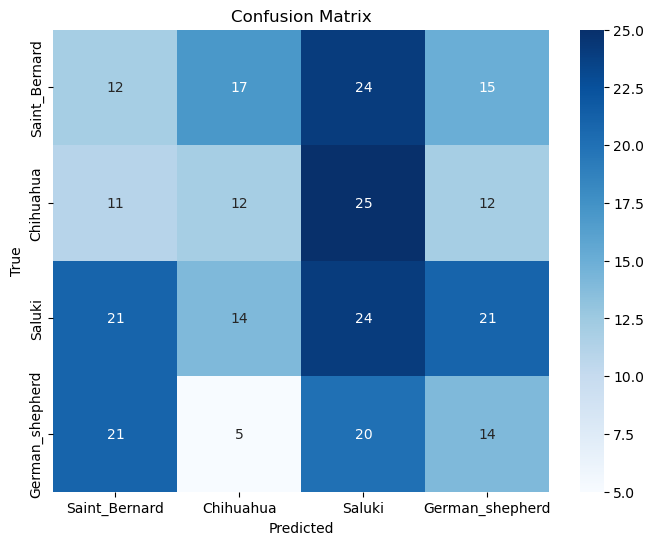

In [33]:
get_confusion_matrix(model, validation_generator, classes)

**Analyse**

 - Saint_Bernard: Sur 68 (12+17+24+15) Saint_Bernard, seulement 12 ont été correctement classés. Le modèle confond souvent les Saint_Bernard avec les Saluki (24 erreurs) et les Chihuahua (17 erreurs).
 - Chihuahua: Sur 60 (11+12+25+12) Chihuahua, 12 ont été correctement classés. Il y a une forte confusion avec les Saluki (25 erreurs).
 - Saluki: Sur 80 (21+14+24+21) Saluki, 24 ont été correctement classés, mais il y a une confusion notable avec les autres classes, en particulier avec Saint_Bernard (21 erreurs) et German_shepherd (21 erreurs).
 - German_shepherd: Sur 60 (21+5+20+14) German_shepherd, 14 ont été correctement classés. Le modèle confond souvent les German_shepherd avec Saint_Bernard (21 erreurs) et Saluki (20 erreurs).

**Conclusion**

 - Le modèle montre encore des difficultés significatives à distinguer correctement les races de chiens, bien que les Saluki et German_shepherd soient légèrement mieux reconnus que dans les modèles précédents.
 - Il y a une confusion notable entre Saint_Bernard et Saluki, ainsi qu'entre Chihuahua et Saluki.
 - German_shepherd et Saint_Bernard sont souvent confondus avec d'autres classes, indiquant que le modèle a des difficultés à les distinguer.

# Optimisation du modèle

Ajout des couches supplémentaires pour augmenter la capacité du modèle à apprendre des caractéristiques complexes

In [16]:

# Création du modèle personnalisé en ajoutant les nouvelles couches au-dessus de VGG-16
model_opt = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(len(classes), activation='softmax')
])



In [17]:
# Compiler le modèle avec un optimiseur avancé
model_opt.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Afficher le résumé du modèle
model_opt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                      

In [19]:
# Entraîner le modèle
history_opt = model_opt.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,  
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
33/33 [==============================] - 382s 12s/step - loss: 1.1194 - accuracy: 0.5668 - val_loss: 1.1842 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 2/20
33/33 [==============================] - 166s 5s/step - loss: 0.5429 - accuracy: 0.8025 - val_loss: 1.0963 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 3/20
33/33 [==============================] - 181s 6s/step - loss: 0.4045 - accuracy: 0.8438 - val_loss: 0.6878 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/20
33/33 [==============================] - 190s 6s/step - loss: 0.3523 - accuracy: 0.8655 - val_loss: 0.8899 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 5/20
33/33 [==============================] - 195s 6s/step - loss: 0.2414 - accuracy: 0.9170 - val_loss: 0.5199 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 6/20
33/33 [==============================] - 198s 6s/step - loss: 0.2364 - accuracy: 0.9179 - val_loss: 1.3368 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 7/20
33/33 [==============================] - 202s 6s/step - loss: 0.

###### Matrice de confusion 

9/9 [==============================] - 31s 3s/step


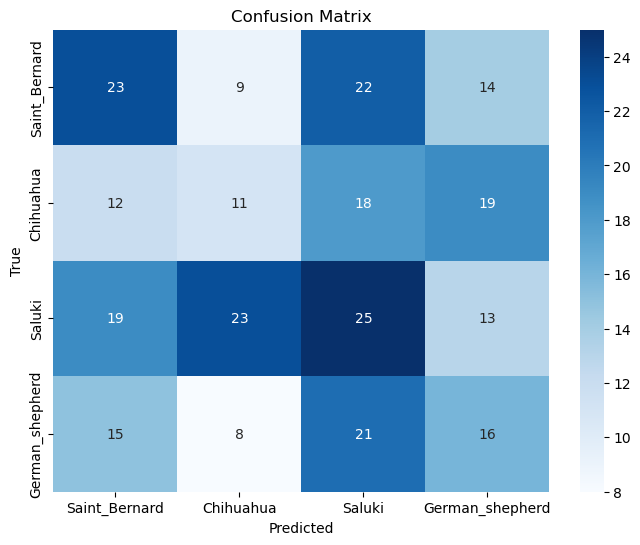

In [34]:
get_confusion_matrix(model_opt, validation_generator, classes)

**Analyse**

 - Saint_Bernard: Sur 68 (23+9+22+14) Saint_Bernard, 23 ont été correctement classés. Le modèle confond souvent les Saint_Bernard avec les Saluki (22 erreurs).
 - Chihuahua: Sur 60 (12+11+18+19) Chihuahua, 11 ont été correctement classés. Il y a une forte confusion avec les Saluki (18 erreurs) et les German_shepherd (19 erreurs).
 - Saluki: Sur 80 (19+23+25+13) Saluki, 25 ont été correctement classés, mais il y a une confusion notable avec les autres classes, en particulier avec Chihuahua (23 erreurs).
 - German_shepherd: Sur 60 (15+8+21+16) German_shepherd, 16 ont été correctement classés. Le modèle confond souvent les German_shepherd avec les Saluki (21 erreurs).

**Conclusion**

 - Le modèle montre encore des difficultés significatives à distinguer correctement les races de chiens, bien que les Saint_Bernard et Saluki soient mieux reconnus que dans les modèles précédents.
 - Il y a une confusion notable entre Saint_Bernard et Saluki, ainsi qu'entre Chihuahua et Saluki.
 - German_shepherd et Chihuahua sont souvent confondus avec d'autres classes, indiquant que le modèle a des difficultés à les distinguer.

###### Evaluation 

In [20]:
# Évaluation des performances du modèle optimisé sur le jeu de validation
eval_optimized = model_opt.evaluate(validation_generator)
print(f'Model Optimized - Validation Loss: {eval_optimized[0]}, Validation Accuracy: {eval_optimized[1]}')


9/9 [==============================] - 42s 5s/step - loss: 0.2218 - accuracy: 0.8955
Model Optimized - Validation Loss: 0.22183385491371155, Validation Accuracy: 0.89552241563797


In [21]:


# Evaluate initial model
eval_initial = model.evaluate(validation_generator)
initial_results = {'Model': 'Initial',
                   ' Accuracy': eval_initial[1],
                  ' Loss': eval_initial[0]}

# Evaluate optimized model (assuming model_optimized is defined)
eval_optimized = model_opt.evaluate(validation_generator)
optimized_results = {'Model': 'Optimized',
                     ' Accuracy': eval_optimized[1],
                    ' Loss': eval_optimized[0]}

# Combine results into a DataFrame
results_df = pd.DataFrame([initial_results, optimized_results])



9/9 [==============================] - 44s 5s/step - loss: 0.2053 - accuracy: 0.8993


In [22]:
results_df

,Model,Accuracy,Loss
0,Initial,0.891791,0.281888
1,Optimized,0.899254,0.205321


Sauvegarder le meilleur modele pour l'utiliser dans le prochain notebook

In [23]:
# Sauvegarder le modèle et l'optimiseur
model_opt.save('model_final_notebook.h5')

/Users/eya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Courbe d'apprentissage

In [24]:
def plot_learningCurve(history): 
    # Récupérer l'historique de l'entraînement
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # Tracer la précision
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Précision entraînement')
    plt.plot(epochs, val_acc, 'r', label='Précision validation')
    plt.title('Précision entraînement et validation')
    plt.legend()

    # Tracer la perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Perte entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte validation')
    plt.title('Perte entraînement et validation')
    plt.legend()

    plt.show()

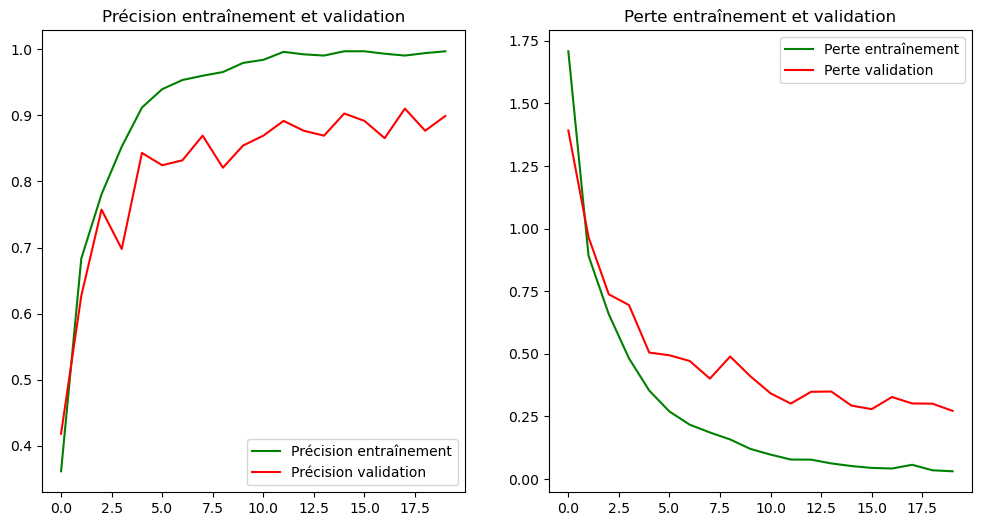

In [25]:
plot_learningCurve(history)

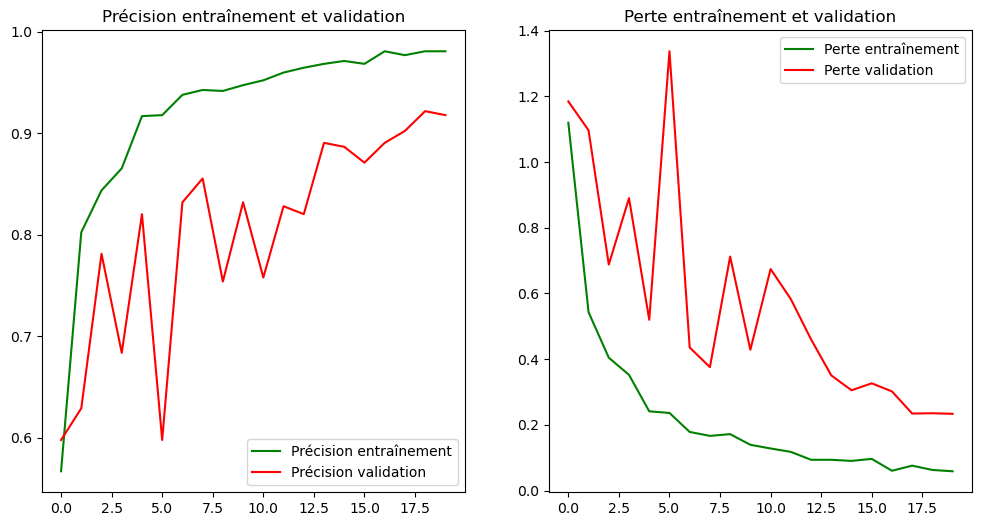

In [26]:
plot_learningCurve(history_opt)